In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import hvplot.pandas
from sklearn.cluster import KMeans
import numpy as np


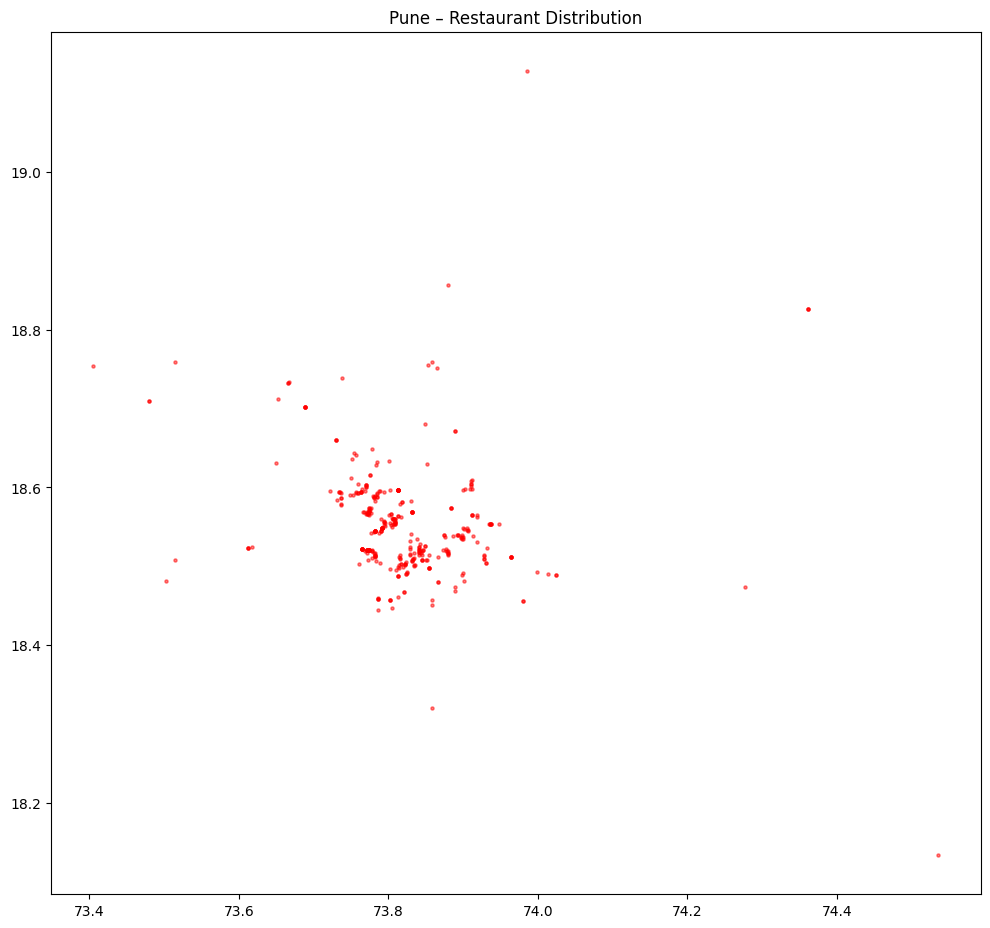

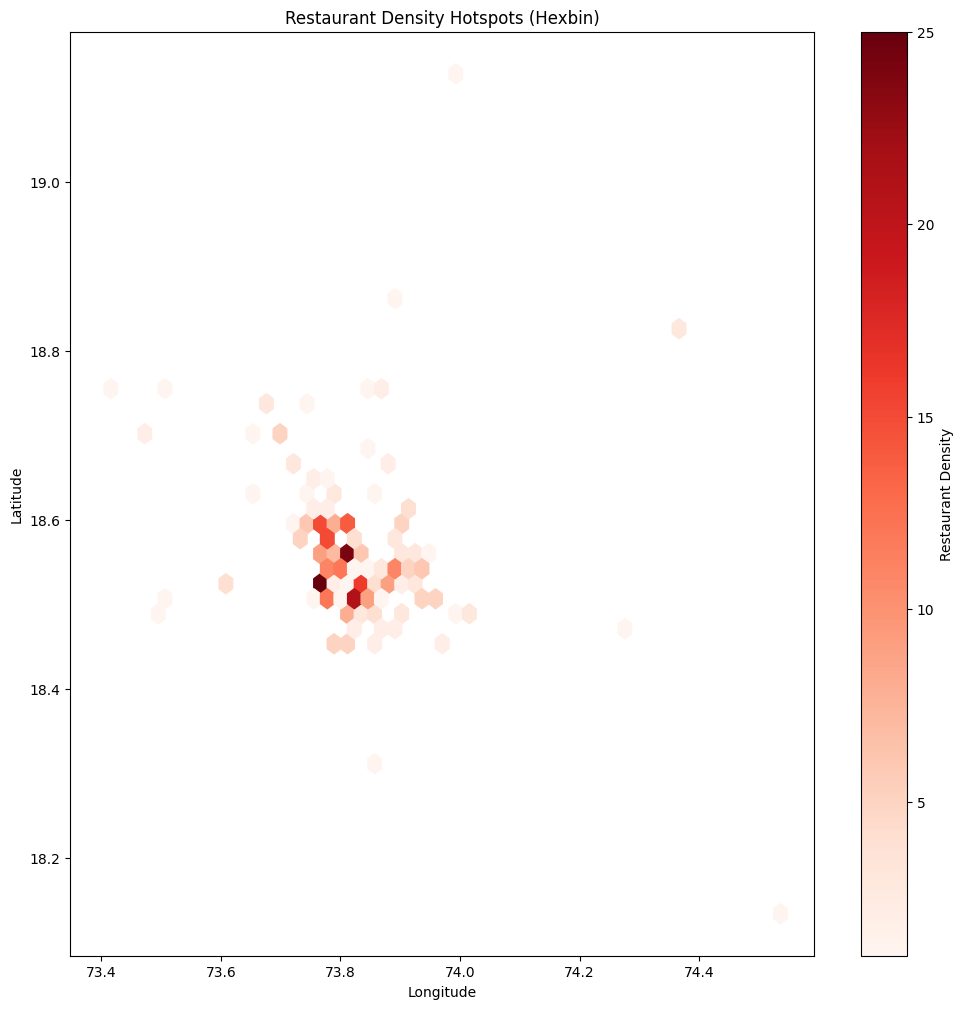

In [4]:

restaurants = gpd.read_file("data/restaurants_clean.geojson")
ngos = gpd.read_file("data/pune_ngos_geocoded_fixed.csv")
waste = pd.read_csv("data/pune_waste_cleaned.csv")

# Basic scatter plot
ax = restaurants.plot(
    figsize=(12, 12),
    alpha=0.5,
    markersize=5,
    color="red"
)
plt.title("Pune – Restaurant Distribution")
plt.show()

# Prepare for hexbin
restaurants["x"] = restaurants.geometry.x
restaurants["y"] = restaurants.geometry.y

# Drop rows with missing coords
restaurants = restaurants.dropna(subset=["x", "y"])

plt.figure(figsize=(12, 12))

plt.hexbin(
    restaurants["x"],
    restaurants["y"],
    gridsize=50,
    cmap="Reds",
    mincnt=1
)

plt.colorbar(label="Restaurant Density")
plt.title("Restaurant Density Hotspots (Hexbin)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

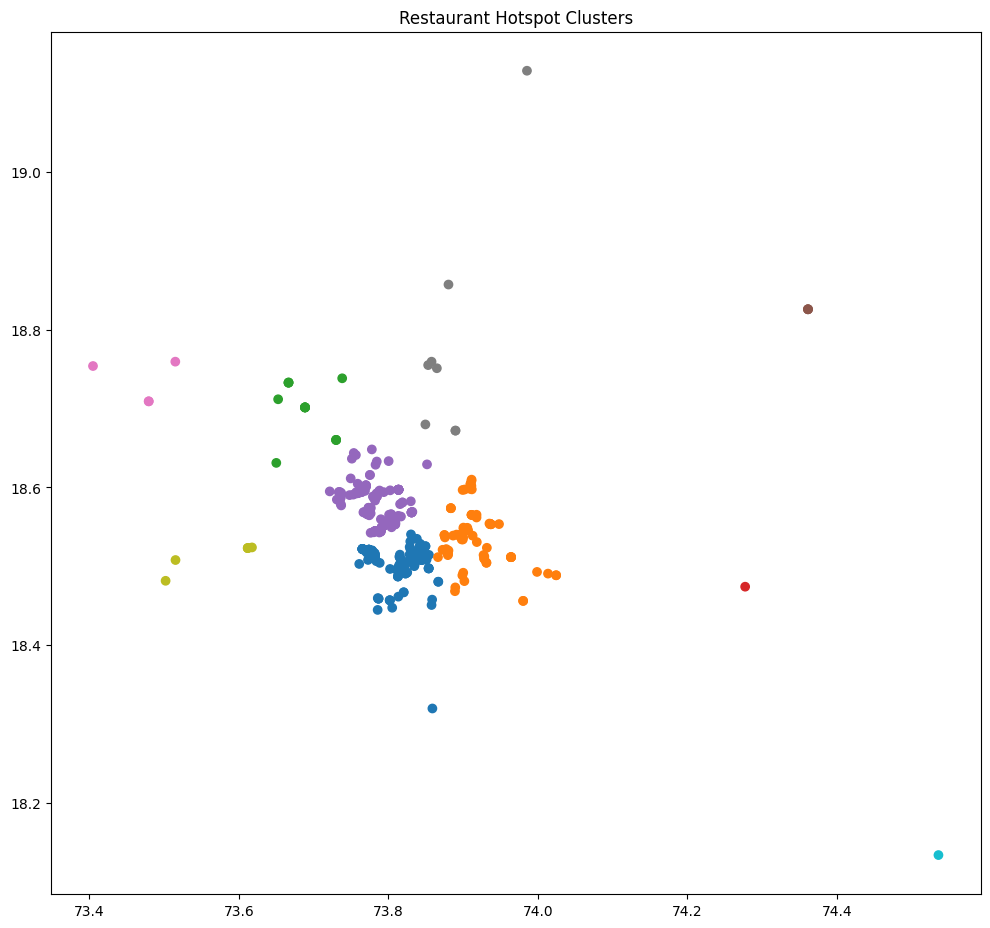

In [6]:
coords = np.column_stack([restaurants.geometry.x, restaurants.geometry.y])

kmeans = KMeans(n_clusters=10, random_state=42)
restaurants['cluster'] = kmeans.fit_predict(coords)
restaurants.plot(column='cluster', cmap='tab10', figsize=(12, 12))
plt.title("Restaurant Hotspot Clusters")
plt.show()


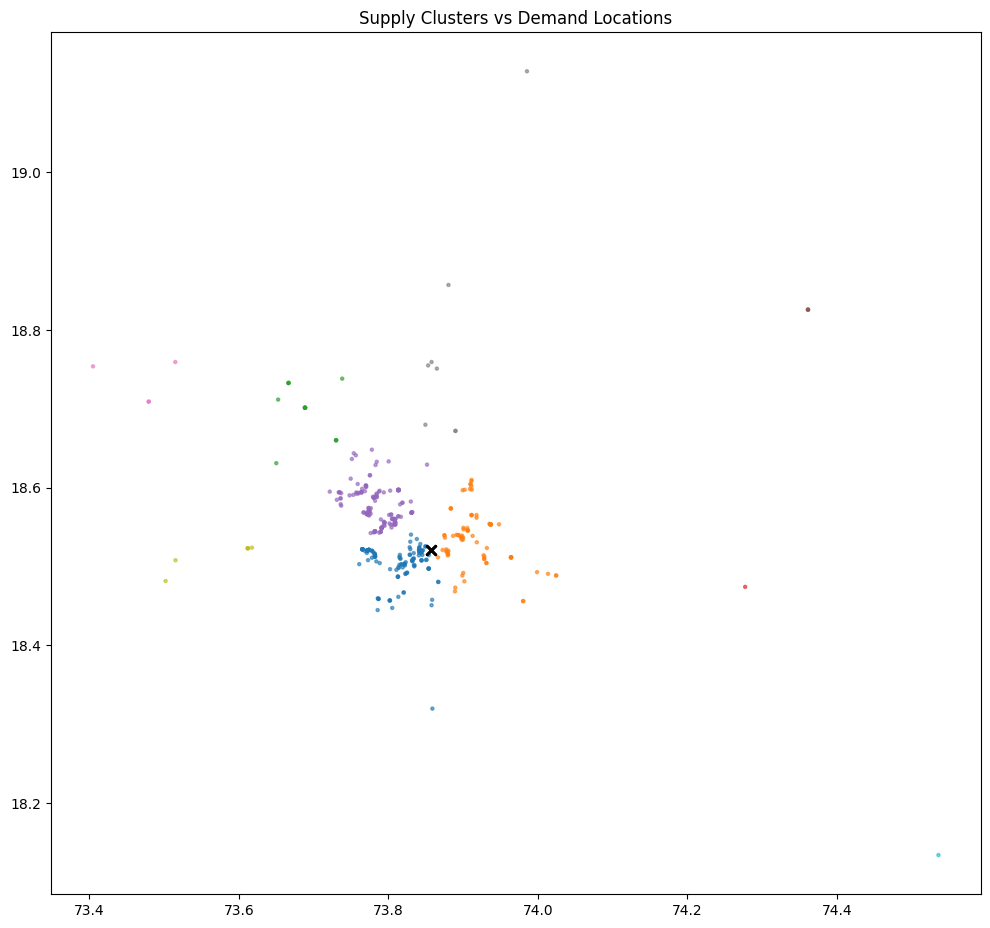

In [30]:
valid_ngos = ngos.dropna(subset=['geometry'])
valid_ngos = valid_ngos[valid_ngos.is_valid]

fig, ax = plt.subplots(figsize=(12,12))

restaurants.plot(ax=ax, column='cluster', markersize=5, cmap='tab10', alpha=0.6)

if len(valid_ngos) > 0:
    valid_ngos.plot(ax=ax, color='black', markersize=50, marker='x')
else:
    print("⚠️ No valid NGO coordinates — skipping NGO plot")

plt.title("Supply Clusters vs Demand Locations")
plt.show()


In [9]:
wards = gpd.read_file("data/pune-electoral-wards_2022.geojson")
wards = wards[["wardnum", "geometry"]]


In [48]:
restaurants = gpd.sjoin(
    restaurants,
    wards,
    how="left",
    predicate="within"
)


In [49]:
restaurants_with_waste = restaurants.merge(
    waste[["wardnum", "waste_tpd"]],
    on="wardnum",
    how="left"
)


In [50]:
# Clean leftover columns
restaurants = restaurants.drop(columns=['wardnum_left', 'wardnum_right', 'index_right'], errors='ignore')

# Merge correctly
restaurants_with_waste = restaurants.merge(
    waste[['wardnum', 'waste_tpd', 'num_households', 'segregated_households']],
    on='wardnum',
    how='left'
)

restaurants_with_waste.head()


,name,cuisine,avg_cost,rating,geometry,x,y,cluster,wardnum,waste_tpd,num_households,segregated_households
0,Garden Court,"North Indian, Chinese, Seafood","₹1,400",2.5,POINT (73.78845 18.50427),73.788450,18.504265,0,33.0,39.69,87673.0,87673.0
1,Sunny Da Dhaba,"North Indian, Mughlai, Chinese","₹2,000",3.8,POINT (73.51494 18.75942),73.514939,18.759415,6,NaN,66.53,173633.0,173633.0
2,Sagar Inn,"North Indian, Chinese",₹800,3.3,POINT (73.61751 18.52387),73.617509,18.523867,8,NaN,66.53,173633.0,173633.0
3,Baba Food Mall,"Chinese, North Indian",₹550,3.8,POINT (73.82855 18.52437),73.828545,18.524374,0,15.0,NaN,NaN,NaN
4,NCC Canteen,"Fast Food, North Indian, South Indian, Chinese",₹500,3.5,POINT (73.82944 18.52188),73.829436,18.521878,0,16.0,53.87,101222.0,101222.0


In [66]:
restaurants_with_waste[['waste_tpd','avg_cost','rating']].corr()


,waste_tpd,avg_cost,rating
waste_tpd,1.000000,-0.102867,-0.104440
avg_cost,-0.102867,1.000000,0.346271
rating,-0.104440,0.346271,1.000000


In [70]:
restaurants['ward_count'] = restaurants.groupby('wardnum')['wardnum'].transform('count')


In [68]:
waste['daily_waste_kg'] = waste['waste_tpd'] * 1000
waste['waste_density'] = waste['daily_waste_kg'] / waste['num_households']


In [71]:
restaurants = restaurants.merge(
    waste[['wardnum', 'waste_density']], 
    on='wardnum', 
    how='left'
)


In [73]:
hotspots = (
    restaurants[['wardnum', 'ward_count']]
    .drop_duplicates()
    .sort_values(by='ward_count', ascending=False)
)

hotspots.head(10)


,wardnum,ward_count
137,14.0,40.0
31,12.0,37.0
4,16.0,32.0
38,13.0,19.0
6,21.0,13.0
0,33.0,13.0
68,3.0,12.0
117,32.0,10.0
13,11.0,10.0
10,24.0,7.0


In [75]:
restaurants.to_file("restaurants_clustered.geojson", driver="GeoJSON")
ngos.to_file("ngos_clustered.geojson", driver="GeoJSON")
